Analyze the results from LSTM

In [1]:
run_python_script = False

False

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time

if not run_python_script:
    plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from models.lstm import LSTM_SGM
from utils.standardize import std_mat, std_vec

In [6]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

df_dtype = torch.float32
torch.set_default_dtype(df_dtype)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

# Data, fn and paras

In [10]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [11]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = np.array(["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"])

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

In [12]:
std_fn = lambda x: (x-x.mean(axis=-1, keepdims=True))/x.std(axis=-1, keepdims=True)

<function __main__.<lambda>(x)>

In [13]:
def ana_corr(data_org, data_rec):
    corrs_psd = []
    for ix in range(data_org.shape[0]):
        seq_x = data_org[ix]
        seq_y = data_rec[ix]
        res = scipy.stats.pearsonr(seq_x, seq_y)
        corrs_psd.append(res[0])
        
        
    data_org_std = std_mat(data_org)
    data_rec_std = std_mat(data_rec)
    corr_psd_uni = scipy.stats.pearsonr(
        data_org_std.mean(axis=0), 
        data_rec_std.mean(axis=0))[0]
    
    corrs_sp = []
    for ix in range(data_org.shape[1]):
        seq_x = data_org[:, ix]
        seq_y = data_rec[:, ix]
        res = scipy.stats.pearsonr(seq_x, seq_y)
        corrs_sp.append(res[0])
    return corr_psd_uni, corrs_psd, corrs_sp

# Load the model

In [50]:
fixed = "_wmse"
data = "ctrlwavelet"
trained_model_lstm = load_pkl_folder2dict(RES_ROOT/f"LSTM1_simu_net_{data}{fixed}", excluding=['opt*', "loss_fn"]);
lstm_net = trained_model_lstm.model;

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM1_simu_net_ctrlwavelet_wmse/Rec_PSD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM1_simu_net_ctrlwavelet_wmse/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM1_simu_net_ctrlwavelet_wmse/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM1_simu_net_ctrlwavelet_wmse/paras.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM1_simu_net_ctrlwavelet_wmse/sgm_paramss_est.pkl


## Evaluate

### sgm parameters

In [51]:
trained_model_lstm.Rec_PSD.shape
sgm_paramss_est = trained_model_lstm.sgm_paramss_est;

In [52]:
dy_mask = np.array(trained_model_lstm.paras.dy_mask)

array([1, 1, 1, 1, 1, 1, 0])

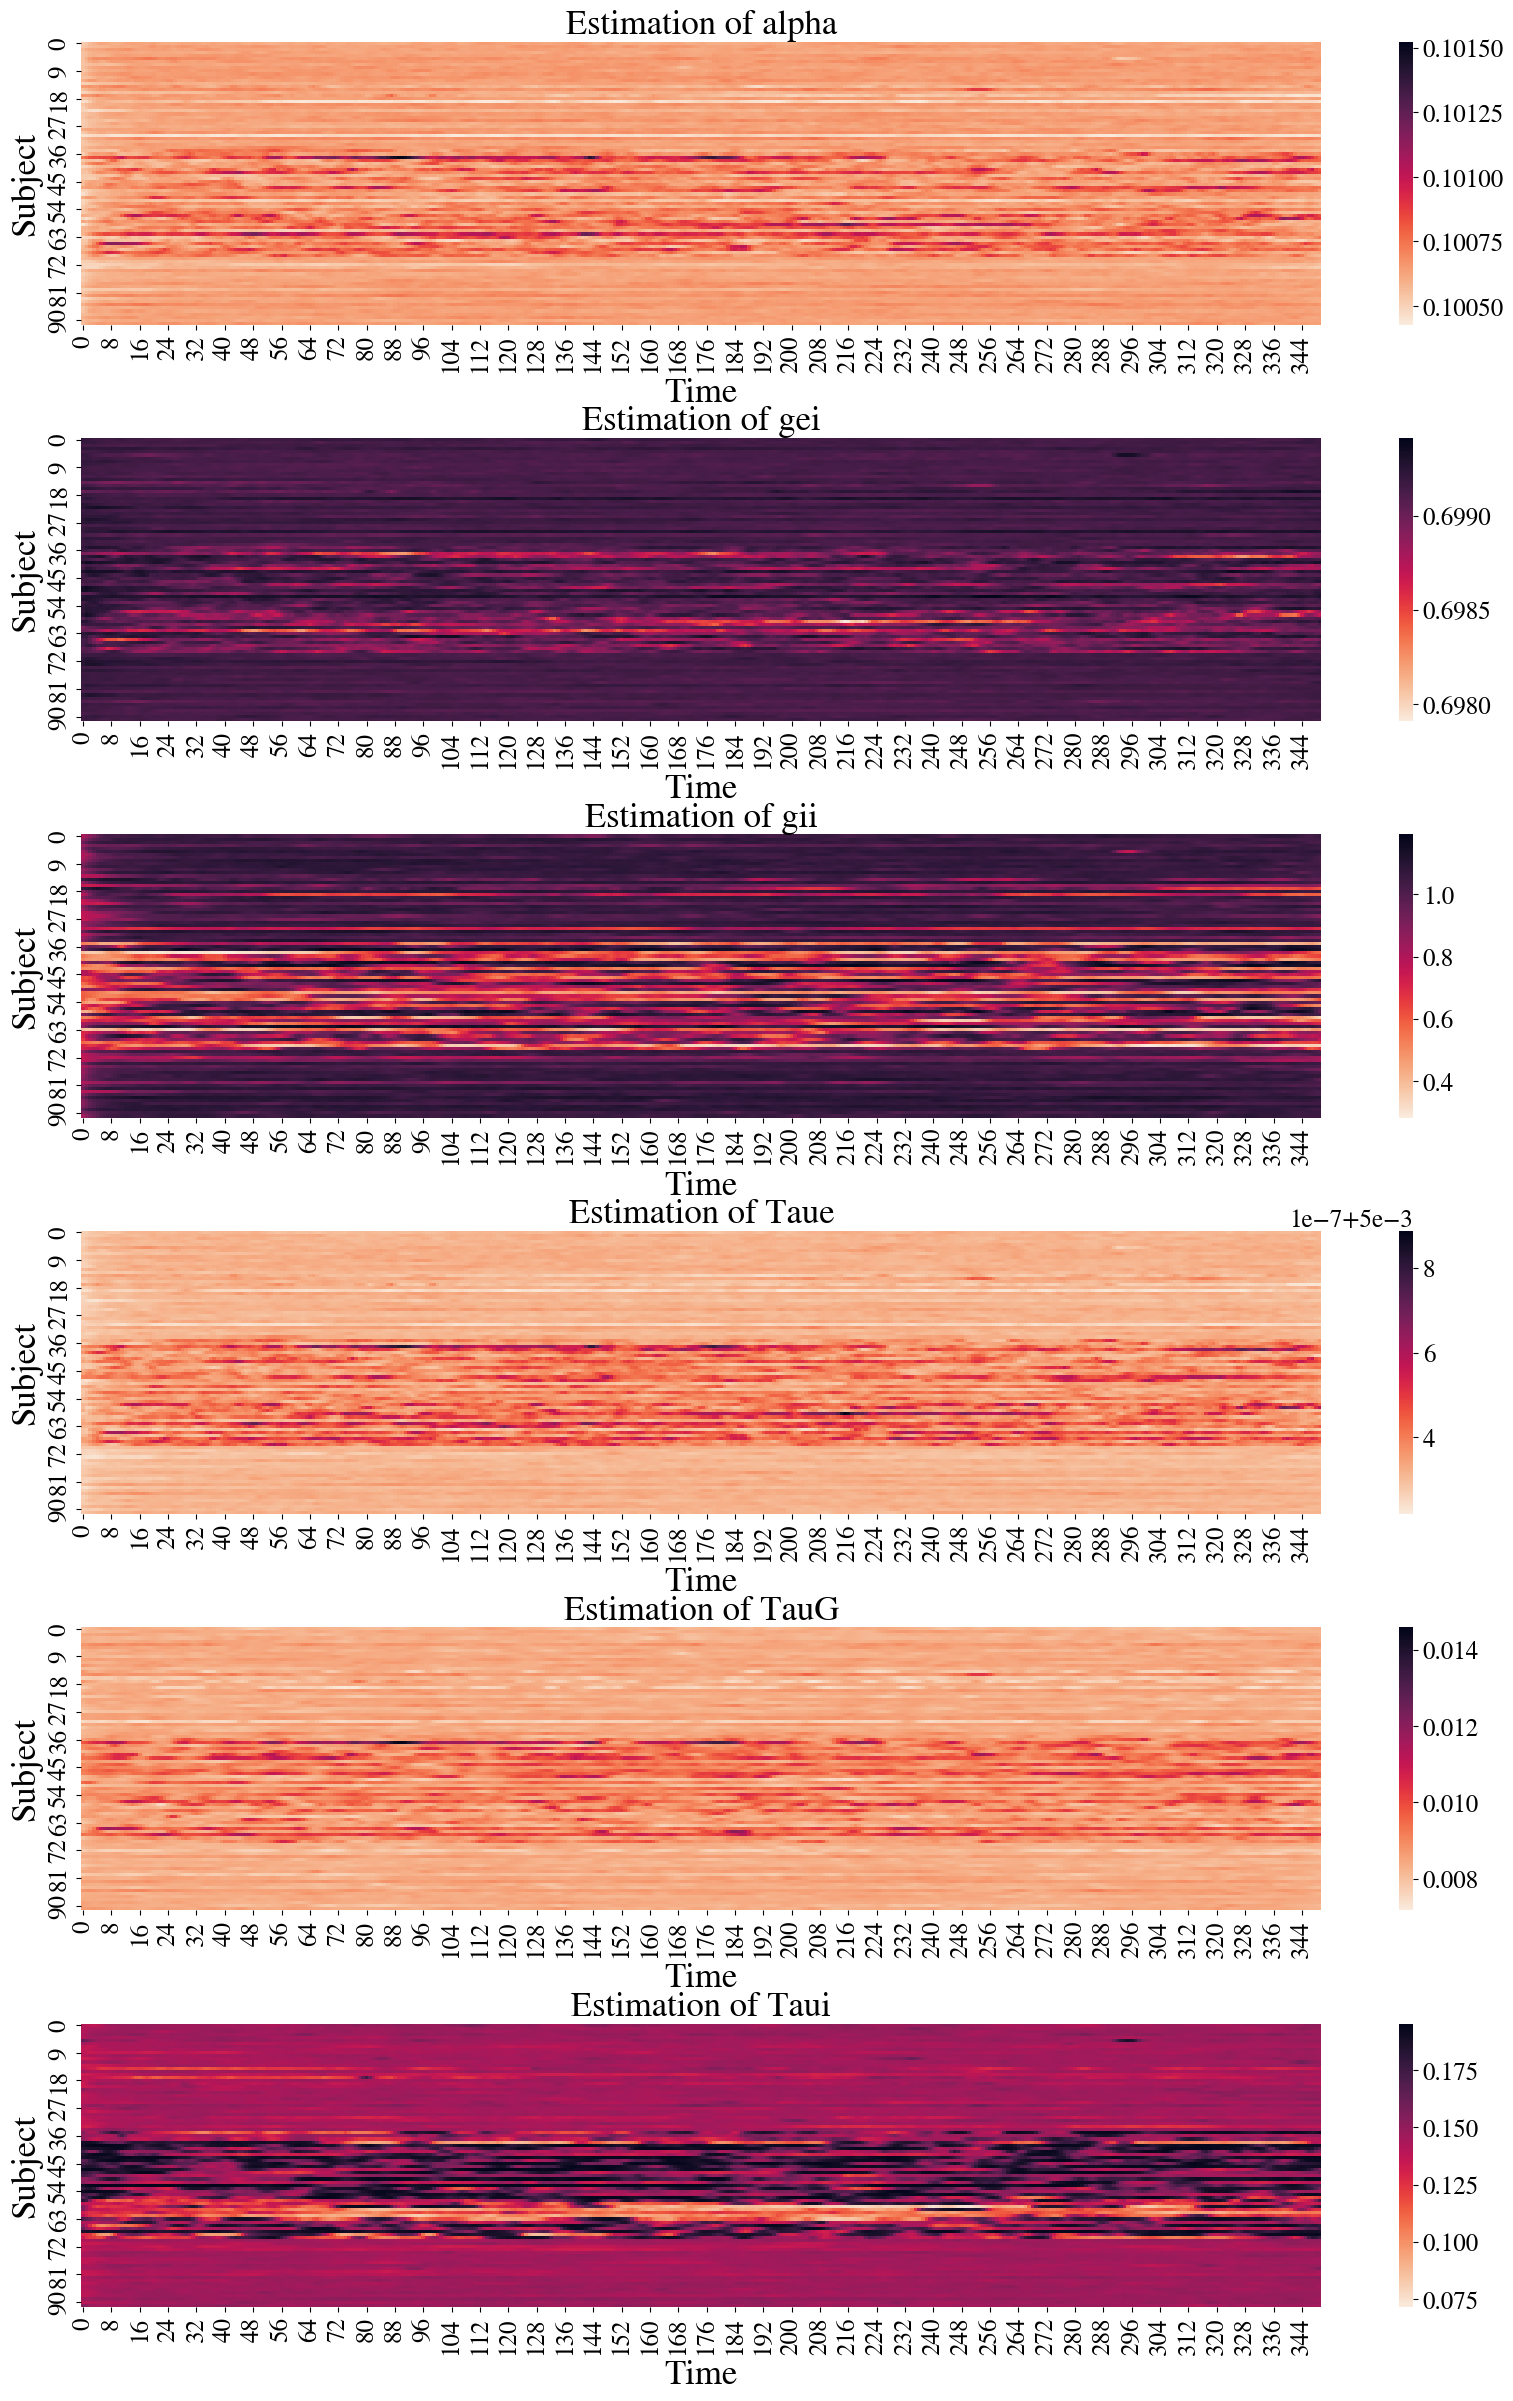

In [53]:
if not run_python_script:
    plt.figure(figsize=[20, 5*np.sum(dy_mask)])
    flag = 0
    for ix in range(7):
        if dy_mask[ix] == 1:
            plt.subplot(np.sum(dy_mask), 1, flag+1)
            plt.title(f"Estimation of {paras.names[ix]}", fontsize=25)
            sns.heatmap(sgm_paramss_est[:, :, ix], cmap="rocket_r")
            plt.xlabel("Time")
            plt.ylabel("Subject")
            flag+=1

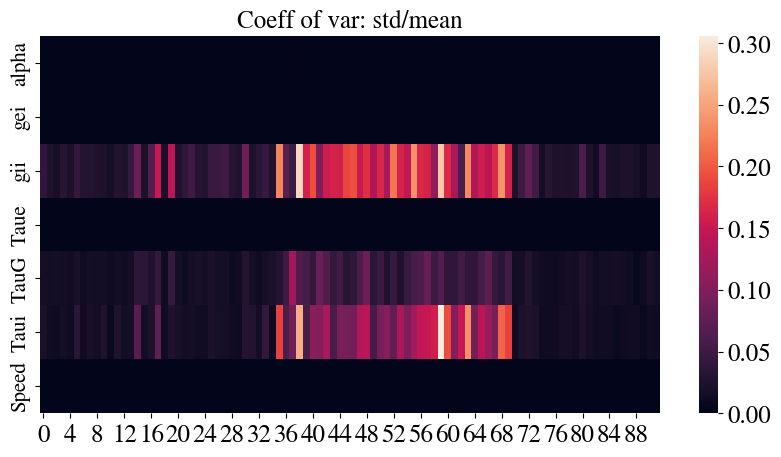

In [54]:
# coefficient of variation, CV=std/mean
if not run_python_script:
    cv1 = sgm_paramss_est.std(axis=1)/sgm_paramss_est.mean(axis=1);
    sns.heatmap(cv1.T)
    plt.yticks(np.arange(7)+0.5, paras.names, fontsize=15);
    plt.title("Coeff of var: std/mean");

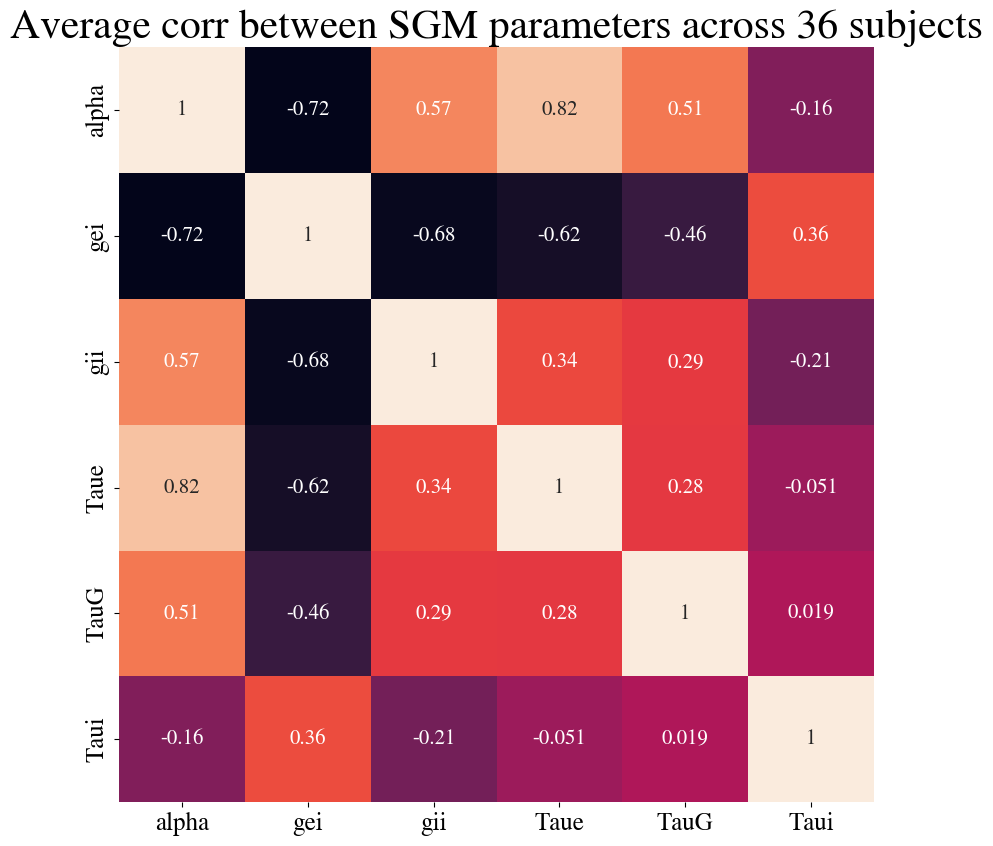

In [55]:
if not run_python_script:
    corr_mat = np.array([np.corrcoef(sgm_params_est[:, dy_mask==1].T) for sgm_params_est in sgm_paramss_est]).mean(axis=0)
    plt.figure(figsize=[10, 10])
    plt.title(f"Average corr between SGM parameters across 36 subjects", fontsize=30)
    sns.heatmap(corr_mat, square=True, annot=True, cbar=False,
                annot_kws=dict(fontsize=15))
    plt.xticks(np.arange(dy_mask.sum())+0.5, paras.names[dy_mask==1])
    plt.yticks(np.arange(dy_mask.sum())+0.5, paras.names[dy_mask==1]);

### Example

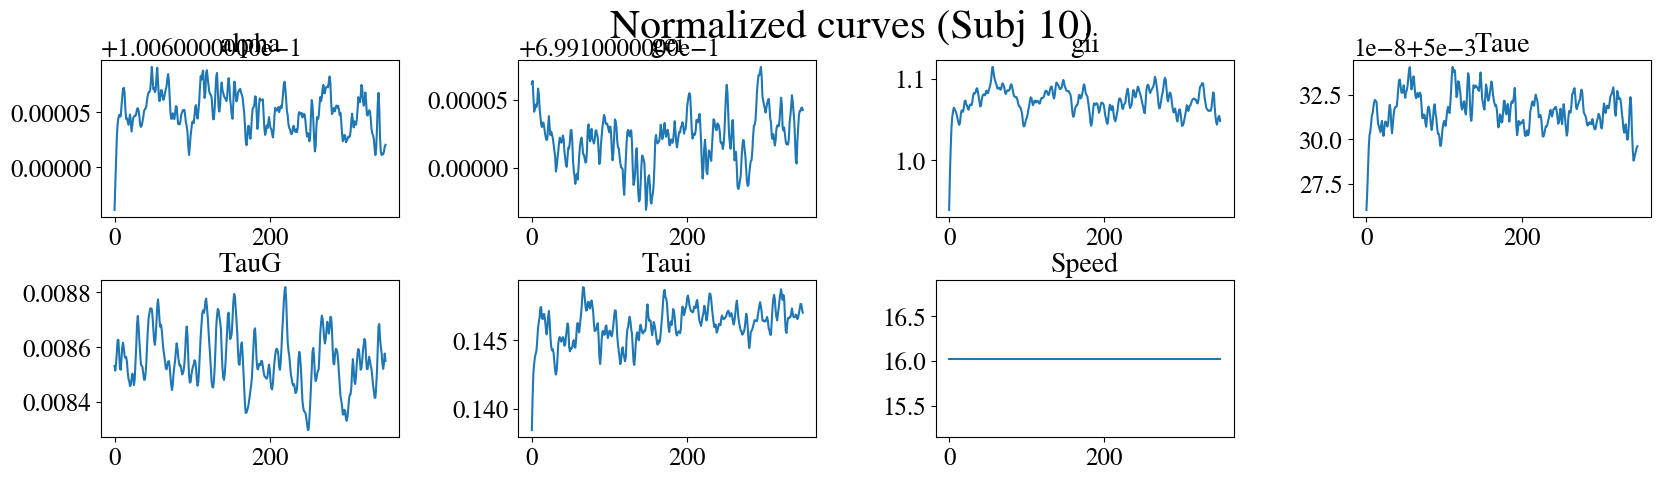

In [59]:
if not run_python_script:
    sub_idx = 10
    sgm_params_est = sgm_paramss_est[sub_idx]
    plt.figure(figsize=[20, 5])
    plt.suptitle(f"Normalized curves (Subj {sub_idx})", fontsize=30)
    for ix in range(7):
        plt.subplot(2, 4, ix+1)
        plt.plot(sgm_params_est[:, ix])
        plt.title(paras.names[ix], fontsize=20)

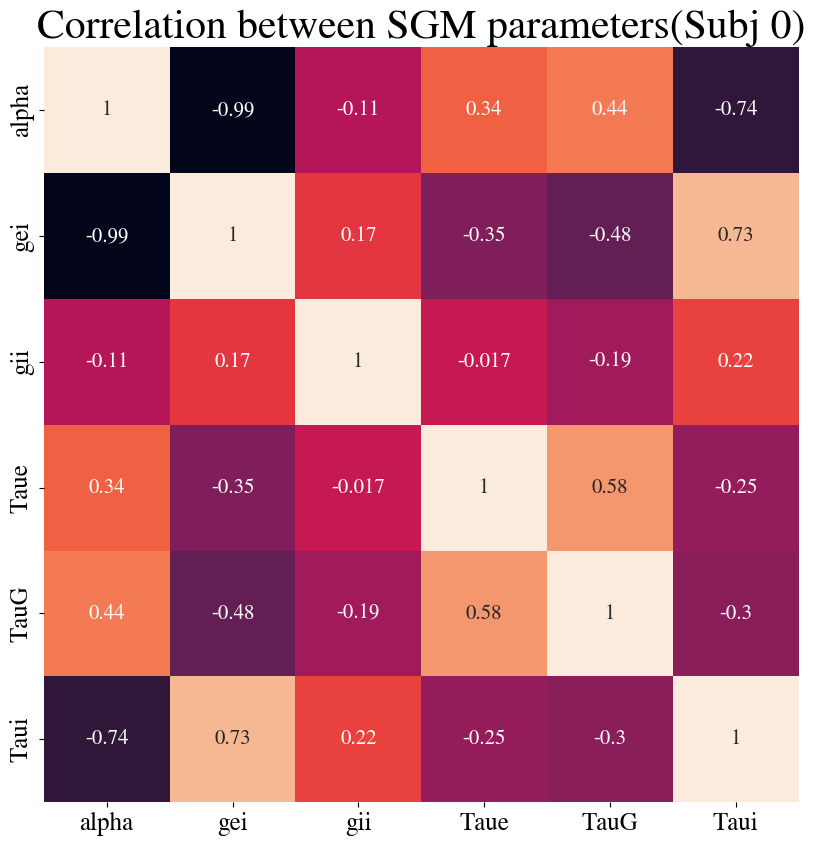

In [49]:
if not run_python_script:
    plt.figure(figsize=[10, 10])
    plt.title(f"Correlation between SGM parameters(Subj {sub_idx})", fontsize=30)
    sns.heatmap(np.corrcoef(sgm_params_est[:, dy_mask==1].T), square=True, annot=True, cbar=False,
                annot_kws=dict(fontsize=15))
    plt.xticks(np.arange(dy_mask.sum())+0.5, paras.names[dy_mask==1])
    plt.yticks(np.arange(dy_mask.sum())+0.5, paras.names[dy_mask==1]);

### PSD

In [8]:
# get order idx
# idx from 36-MEG order to Ctrl-data order
# org_order: ctrl data order
# target_order: SGMnet order, SC order
org_order = np.loadtxt(DATA_ROOT/"AD_vs_Ctrl_ts/roi_order.txt", dtype=str);
target_order0 = np.loadtxt(DATA_ROOT/"DK_atlas_36MEG.txt", dtype=str);
target_order = np.array([f"ctx-{roi_name.split('_')[1].lower()}h-{roi_name.split('_')[0].lower()}" for roi_name in target_order0[:68]]);
org2target_idxs = np.array([np.where(org_order==roi)[0][0] for roi in target_order]);
(org_order[org2target_idxs] == target_order).mean()

1.0

In [9]:
psd_all_full0 = load_pkl(DATA_ROOT/"AD_vs_Ctrl_ts/spectrogram_wavelet100.pkl");

psd_all_full = np.array([res["spectrogram"] for res in psd_all_full0]);
psd_all_full = 10 * np.log10(psd_all_full) # to dB scale
# make the ctrl data order is compatible to SGM net 
psd_all_full = psd_all_full[:, org2target_idxs] # num_sub x num_roi x num_freqs x num_ts
time_points = psd_all_full0[0]["times"]
freqs = psd_all_full0[0]["freqs"];
#I remove the first and last time pts
rm_lim = 5
if rm_lim > 0:
    psd_all_full = psd_all_full[:, :, :, rm_lim:-rm_lim]
    time_points = time_points[rm_lim:-rm_lim];
    
all_data = psd_all_full.transpose(0, 3, 1, 2)
all_data_std = (all_data - all_data.mean(axis=-1, keepdims=True))/all_data.std(axis=-1, keepdims=True);

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/spectrogram_wavelet100.pkl


In [23]:
# calculate rec PSD and save, only need once
sgmmodel = SGM(paras.C, paras.D, paras.freqs)
Rec_PSD = trained_model_lstm.Rec_PSD;

In [24]:
X_recs = 20*np.log10(trained_model_lstm.Rec_PSD)
X_recs_std = (X_recs - X_recs.mean(axis=-1, keepdims=True))/X_recs.std(axis=-1, keepdims=True);

In [25]:
if "corrss" not in trained_model_lstm.keys():
    corrss = []
    corrss_roiwise = []
    for X_org, X_rec in tqdm(zip(all_data_std, X_recs_std), total=len(X_recs_std)):
        corrs = []
        corrs_roiwise = []
        for ix in range(len(X_org)):
            res =ana_corr(X_org[ix], X_rec[ix])
            
            corrs.append(res[0])
            corrs_roiwise.append(np.mean(res[1]))
        
        corrss.append(corrs)
        corrss_roiwise.append(corrs_roiwise)
        
    trained_model_lstm.corrss = corrss
    trained_model_lstm.corrss_roiwise = corrss_roiwise
    save_pkl_dict2folder(RES_ROOT/f"LSTM_simu_net_ctrl{fixed}", trained_model_lstm, is_force=False)
else:
    corrss = trained_model_lstm.corrss
    corrss_roiwise = trained_model_lstm.corrss_roiwise
    

100%|████████████████████████████████████████████████████████████████████████████| 92/92 [02:19<00:00,  1.51s/it]

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_wmse/Rec_PSD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_wmse/loss.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_wmse/model.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_wmse/paras.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_wmse/sgm_paramss_est.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_wmse/corrss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ct

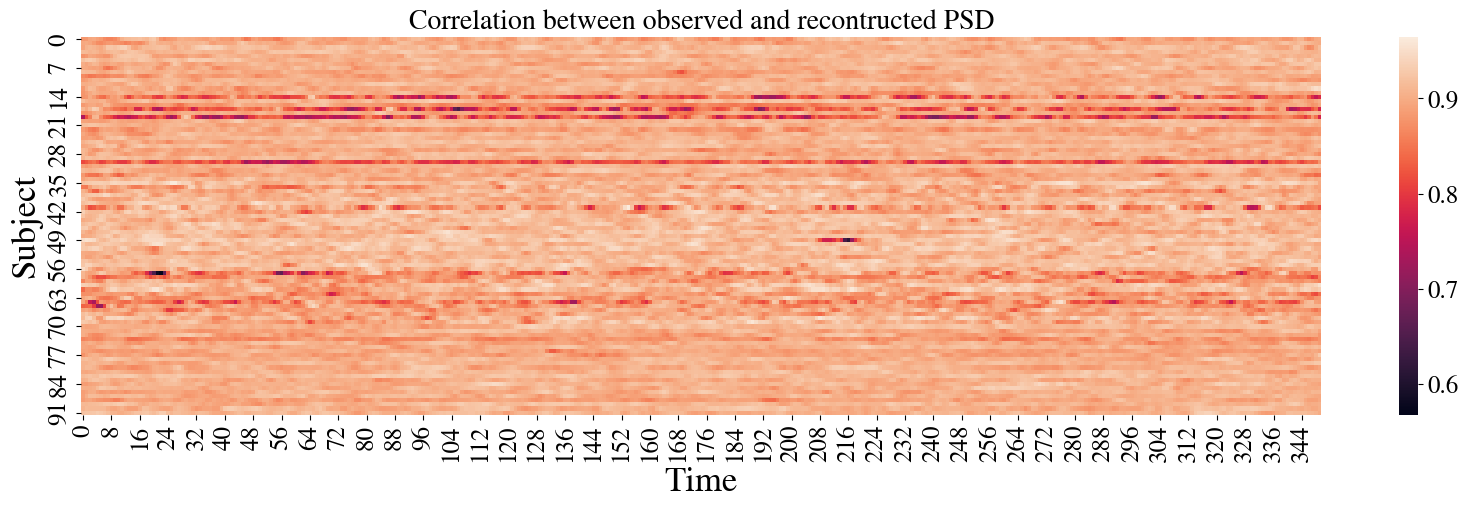

In [26]:
corrss_roiwise = np.array(corrss_roiwise)
corrss = np.array(corrss)
plt.figure(figsize=[20, 5])
plt.title("Correlation between observed and recontructed PSD", fontsize=20)
sns.heatmap(corrss, cmap="rocket")
plt.xlabel("Time")
plt.ylabel("Subject");

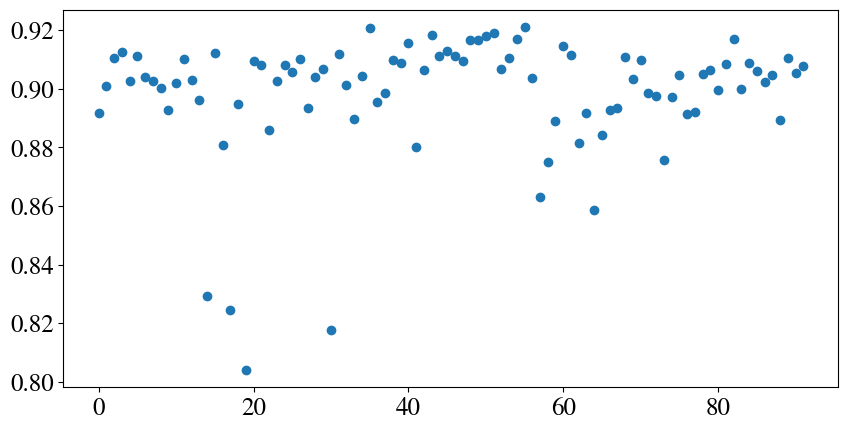

In [27]:
plt.plot(corrss.mean(axis=-1), "o")

In [29]:
corrss_roiwise.shape

(92, 350)

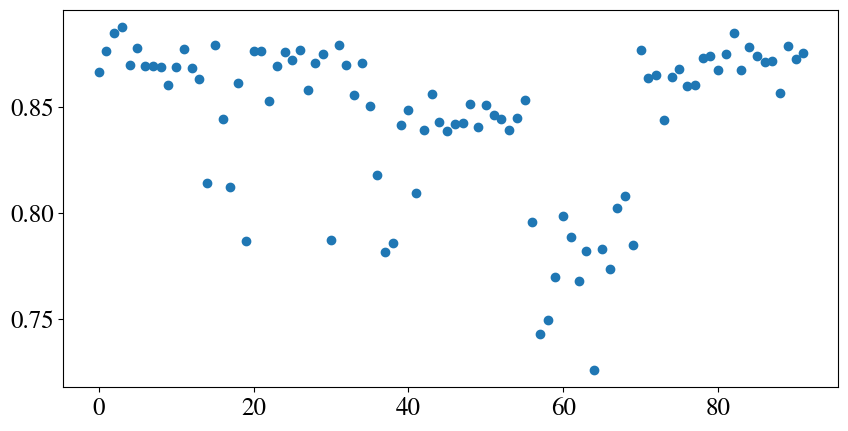

In [31]:
plt.plot(corrss_roiwise.mean(axis=-1), "o")

In [74]:
import pandas as pd
df = pd.DataFrame({
    "mcorr":corrss.mean(axis=-1),  
    "corr": np.median(corrss_roiwise.mean(axis=-1), axis=1)
})
df.sort_values(by="corr").head(n=20)

,mcorr,corr
64,0.785601,0.647687
66,0.793534,0.670901
58,0.824107,0.672868
57,0.805900,0.673473
61,0.815962,0.675776
59,0.816503,0.682591
19,0.708099,0.685413
30,0.726906,0.694458
69,0.824276,0.698057
37,0.830546,0.704090


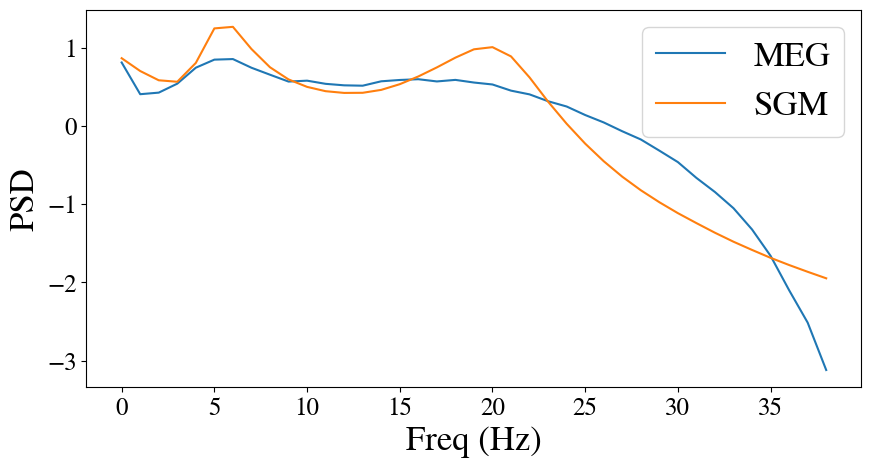

In [32]:
# example
sub_idx = 29
time_idx = 2
plt.plot(std_mat(all_data_std[sub_idx, time_idx]).mean(axis=0), label="MEG")
plt.plot(std_mat(X_recs[sub_idx, time_idx]).mean(axis=0), label="SGM")
plt.xlabel("Freq (Hz)")
plt.ylabel("PSD")
plt.legend()

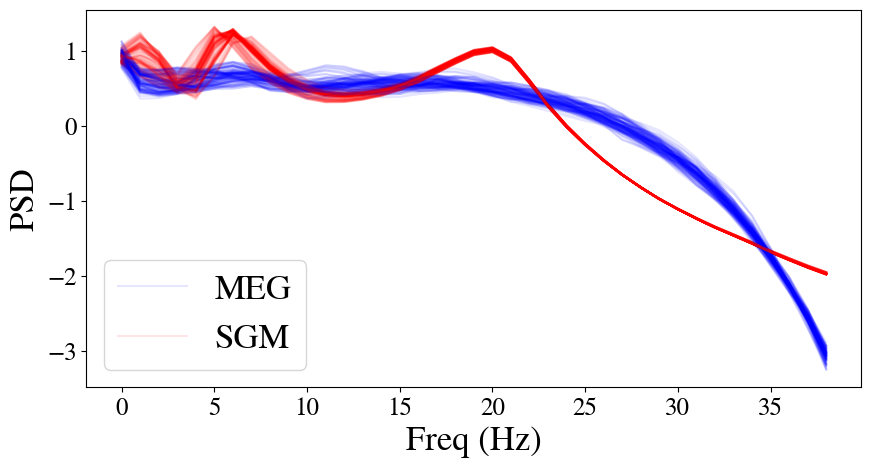

In [33]:
sub_idx = 24 # best 2, 23
#sub_idx = 24 # worst 12, 24
for ix in range(119):
    if ix == 0:
        plt.plot(std_mat(all_data_std[sub_idx, ix]).mean(axis=0), color="blue", alpha=0.1, label="MEG")
        plt.plot(std_mat(X_recs_std[sub_idx, ix]).mean(axis=0), color="red", alpha=0.1, label="SGM")
    else:
        plt.plot(std_mat(all_data_std[sub_idx, ix]).mean(axis=0), color="blue", alpha=0.1)
        plt.plot(std_mat(X_recs_std[sub_idx, ix]).mean(axis=0), color="red", alpha=0.1)
plt.xlabel("Freq (Hz)")
plt.ylabel("PSD")
plt.legend()

# Compare 


In [9]:
res_names = ["rep1", "rep2"]

['rep1', 'rep2']

In [34]:
res1 = load_pkl_folder2dict(RES_ROOT/f"corr_res_bak/LSTM_simu_net_ctrlwavelet_corr", excluding=['opt*', "loss_fn"], verbose=True);
res2 = load_pkl_folder2dict(RES_ROOT/f"ctrl_res_bak/LSTM_simu_net_ctrlwavelet_corr", excluding=['opt*', "loss_fn"], verbose=True);

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/corr_res_bak/LSTM_simu_net_ctrlwavelet_corr/Rec_PSD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/corr_res_bak/LSTM_simu_net_ctrlwavelet_corr/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/corr_res_bak/LSTM_simu_net_ctrlwavelet_corr/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/corr_res_bak/LSTM_simu_net_ctrlwavelet_corr/paras.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/corr_res_bak/LSTM_simu_net_ctrlwavelet_corr/sgm_paramss_est.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/ctrl_res_bak/LSTM_simu_net_ctrlwavelet_corr/Rec_PSD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/ctrl_res_bak/LSTM_simu_net_ctrlwavelet_corr/loss.pkl
Load fil

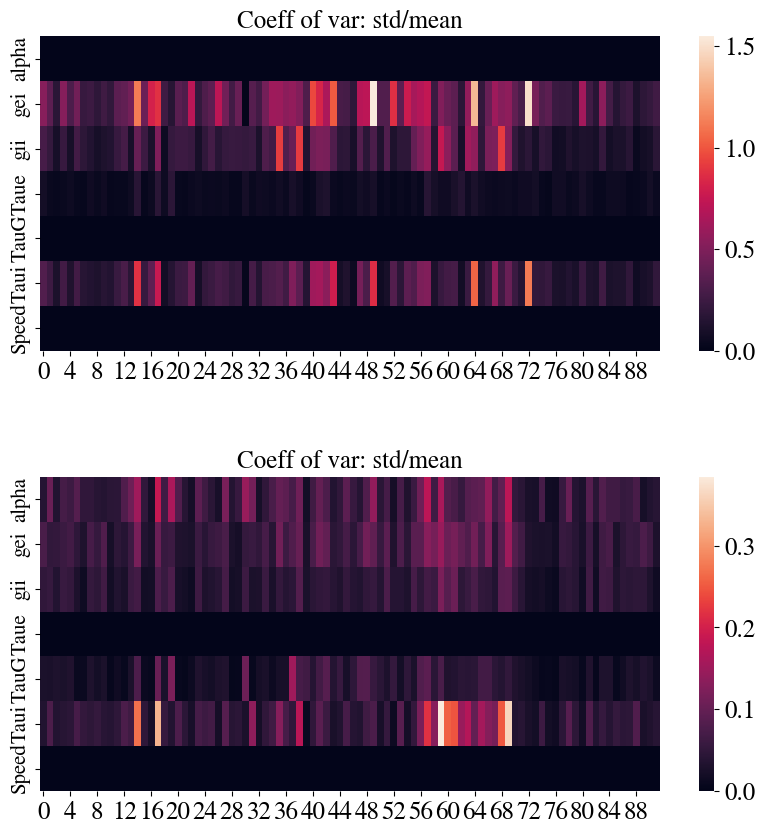

In [35]:
# coefficient of variation, CV=std/mean
cv1 = res1.sgm_paramss_est.std(axis=1)/res1.sgm_paramss_est.mean(axis=1);
cv2 = res2.sgm_paramss_est.std(axis=1)/res2.sgm_paramss_est.mean(axis=1);
plt.figure(figsize=[10, 10])
plt.subplot(211)
sns.heatmap(cv1.T)
plt.yticks(np.arange(7)+0.5, paras.names, fontsize=15);
plt.title("Coeff of var: std/mean");
plt.subplot(212)
sns.heatmap(cv2.T)
plt.yticks(np.arange(7)+0.5, paras.names, fontsize=15);
plt.title("Coeff of var: std/mean");

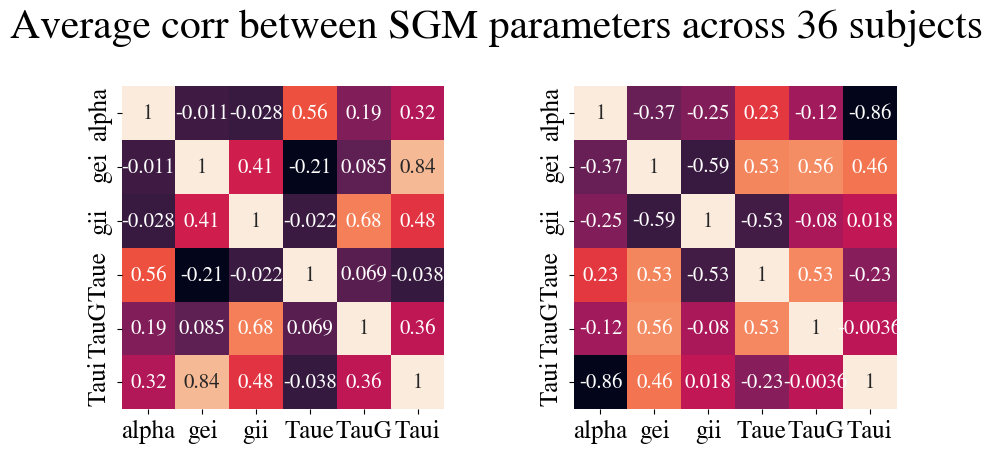

In [36]:
plt.figure(figsize=[10, 5])
plt.suptitle(f"Average corr between SGM parameters across 36 subjects", fontsize=30)
for ix, res in enumerate([res1, res2]):
    plt.subplot(1, 2, ix+1)
    corr_mat = np.array([np.corrcoef(sgm_params_est[:, np.array(res.paras.dy_mask)==1].T) 
                             for sgm_params_est in res.sgm_paramss_est]).mean(axis=0)
    sns.heatmap(corr_mat, square=True, annot=True, cbar=False,
                    annot_kws=dict(fontsize=15))
    plt.xticks(np.arange(np.sum(res.paras.dy_mask))+0.5, paras.names[np.array(res.paras.dy_mask)==1])
    plt.yticks(np.arange(np.sum(res.paras.dy_mask))+0.5, paras.names[np.array(res.paras.dy_mask)==1]);

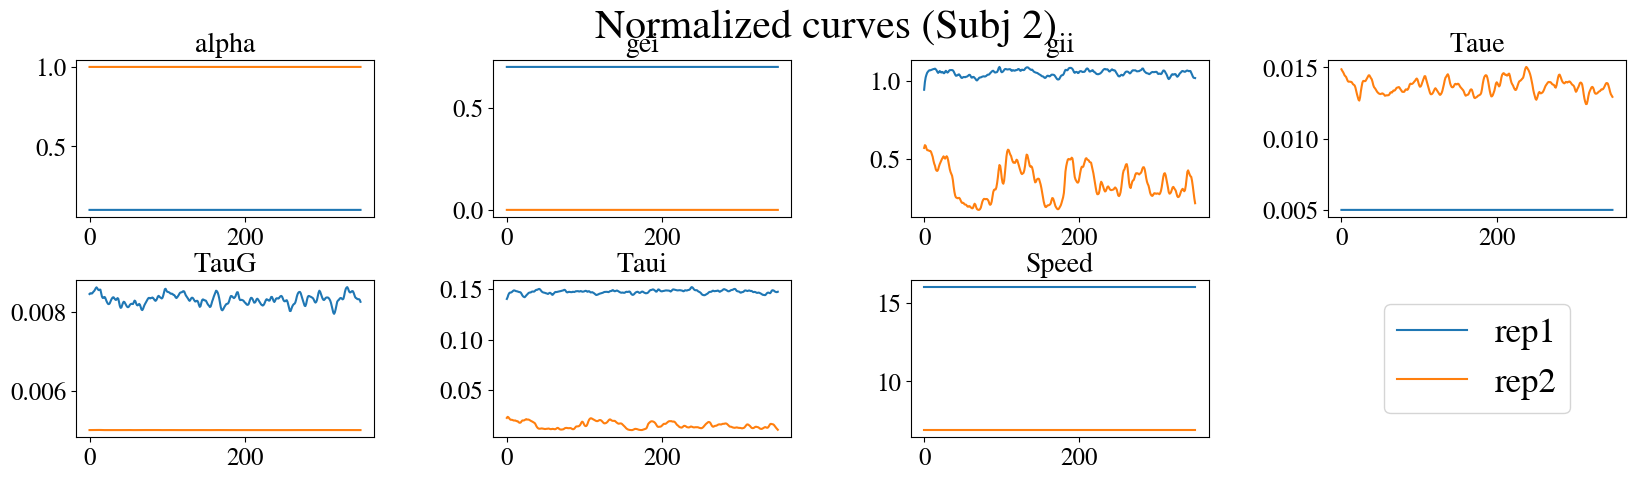

In [20]:
# sample
sub_idx = 2
#time_idx = 0
sgm_params_est1 = res1.sgm_paramss_est[sub_idx]
sgm_params_est2 = res2.sgm_paramss_est[sub_idx]
plt.figure(figsize=[20, 5])
plt.suptitle(f"Normalized curves (Subj {sub_idx})", fontsize=30)
for ix in range(7):
    plt.subplot(2, 4, ix+1)
    plt.plot(sgm_params_est1[:, ix], label=res_names[0])
    plt.plot(sgm_params_est2[:, ix], label=res_names[1])
    plt.title(paras.names[ix], fontsize=20)
    
plt.subplot(2, 4, 8)
plt.axis('off')

fig = plt.gcf()
axes = fig.get_axes()
ax = axes[0]
handles, labels = [], []
for h, l in zip(*ax.get_legend_handles_labels()):
    handles.append(h)
    labels.append(l)

plt.legend(handles, labels, loc='center')